In [1]:
import pandas as pd
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import pickle as pkl

from matplotlib_venn import venn3
import matplotlib.pyplot as plt

In [2]:
def plot_gene_mean_var(X):
    # Compute gene means and variances across all cells
    gene_means = np.array(X.mean(axis=0)).flatten()
    gene_vars = np.array(X.var(axis=0)).flatten()
    
    # Log-transform gene means (add small value to avoid log(0))
    log_gene_means = np.log1p(gene_means)  # log(1 + mean)
    
    # Scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(log_gene_means, gene_vars, s=5, alpha=0.6)
    plt.xlabel("log1p(Gene Mean)")
    plt.ylabel("Gene Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Different normalization strategies

In [3]:
adata = ad.read_h5ad('../../data/sciplex_qc_ann.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 401917 × 27544
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'SMILES', 'fmfp', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'drug_celltype_dose', 'match_index'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## Raw counts

<Axes: ylabel='Count'>

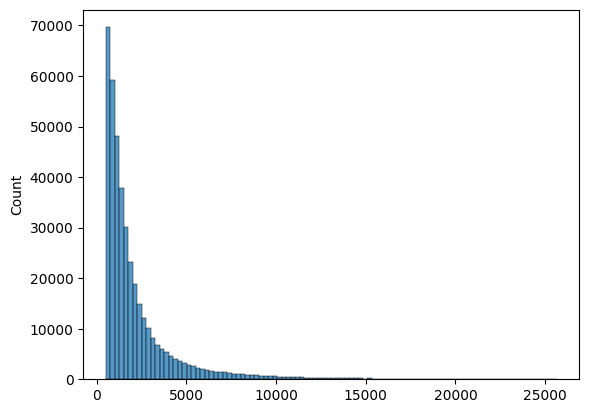

In [5]:
sns.histplot(adata.X.toarray().sum(1), bins=100, kde=False)

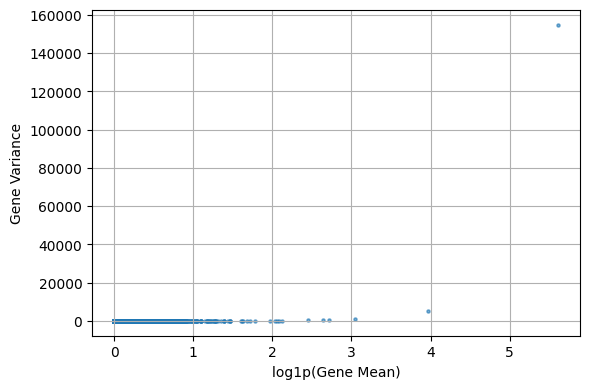

In [6]:
plot_gene_mean_var(adata.X.toarray())

## CPM Normalization

In [7]:
scales_counts = sc.pp.normalize_total(adata, target_sum=1e6, inplace=False)
X_cpm = sc.pp.log1p(scales_counts["X"], copy=True)

<Axes: ylabel='Count'>

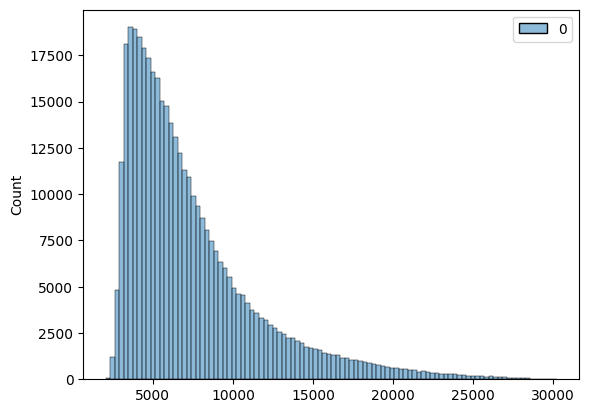

In [8]:
sns.histplot(X_cpm.sum(1), bins=100, kde=False)

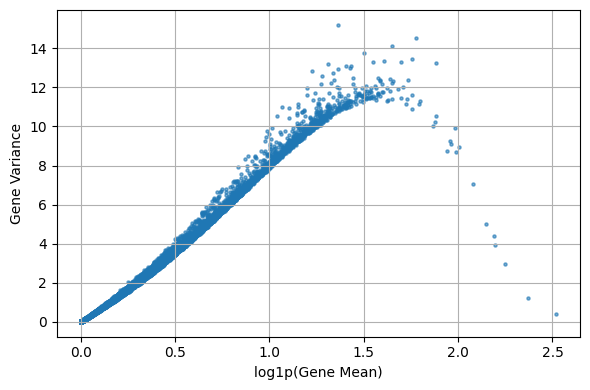

In [9]:
plot_gene_mean_var(X_cpm.toarray())

## Shifted-log Normalization

In [10]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
X_shifted_log = sc.pp.log1p(scales_counts["X"], copy=True)

<Axes: ylabel='Count'>

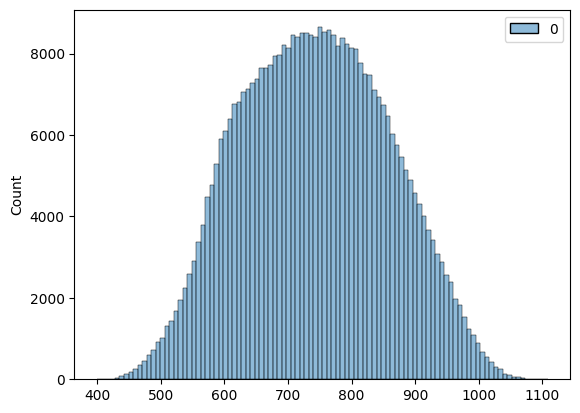

In [11]:
sns.histplot(X_shifted_log.sum(1), bins=100, kde=False)

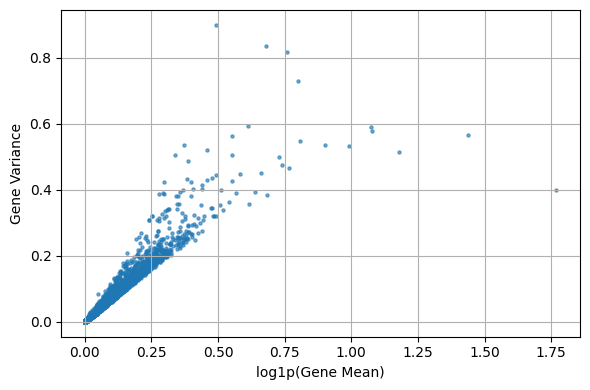

In [12]:
plot_gene_mean_var(X_shifted_log.toarray())

## Analytic Pearsons Residuals

In [4]:
sc.experimental.pp.normalize_pearson_residuals(adata, inplace=True)

<Axes: ylabel='Count'>

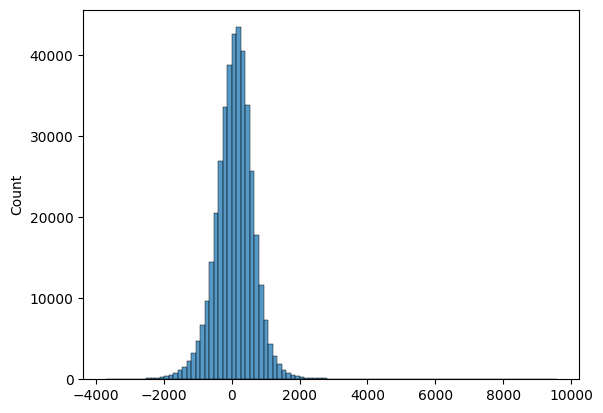

In [5]:
sns.histplot(adata.X.sum(1), bins=100, kde=False)

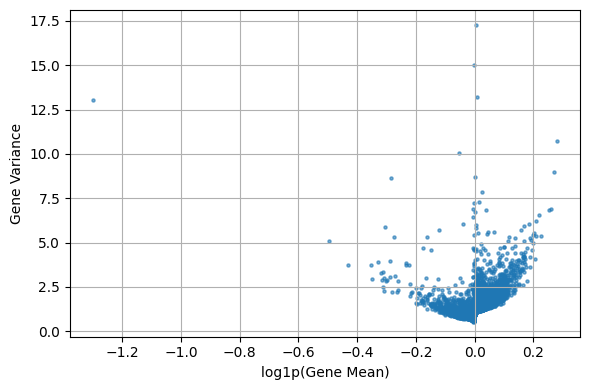

In [7]:
plot_gene_mean_var(adata.X)

## Compute Consensus HVG

In [13]:
def compute_HVG(adata_path, norm_method='shifted_log',n_genes=3500):
    assert norm_method in ['none', 'cpm', 'shifted_log', 'analytic_pearson']

    if norm_method == 'none':
        adata = ad.read_h5ad(adata_path)
        sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=n_genes, inplace=True)
        genes = adata.var_names[adata.var['highly_variable']].tolist()
        return genes

    elif norm_method == 'cpm':
        adata = ad.read_h5ad(adata_path)
        sc.pp.normalize_total(adata, target_sum=1e6, inplace=True)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=n_genes, inplace=True)
        genes = adata.var_names[adata.var['highly_variable']].tolist()
        return genes

    elif norm_method == 'shifted_log':
        adata = ad.read_h5ad(adata_path)
        sc.pp.normalize_total(adata, inplace=True)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=n_genes, inplace=True)
        genes = adata.var_names[adata.var['highly_variable']].tolist()
        return genes

    elif norm_method == 'analytic_pearson':
        adata = ad.read_h5ad(adata_path)
        sc.experimental.pp.highly_variable_genes(adata, n_top_genes=n_genes, inplace=True)
        genes = adata.var_names[adata.var['highly_variable']].tolist()
        return genes
        


In [14]:
genes_raw = compute_HVG("../../data/sciplex_qc_ann.h5ad", norm_method='none', n_genes=5000)
genes_cpm = compute_HVG("../../data/sciplex_qc_ann.h5ad", norm_method='cpm', n_genes=5000)
genes_shiftedlog = compute_HVG("../../data/sciplex_qc_ann.h5ad", norm_method='shifted_log', n_genes=5000)

In [15]:
genes_pearson = compute_HVG("../../data/sciplex_qc_ann.h5ad", norm_method='analytic_pearson', n_genes=5000)

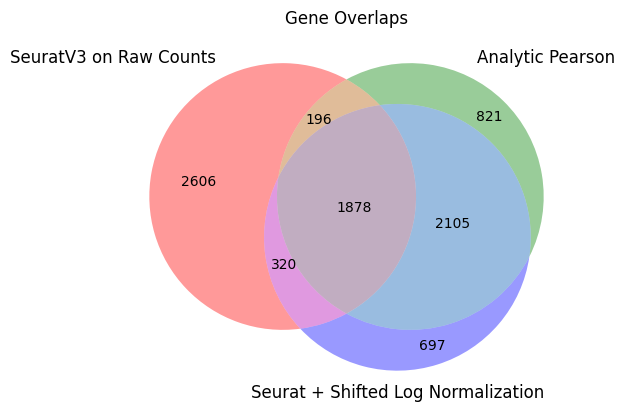

In [16]:
# Convert to sets
set1 = set(genes_raw)
set2 = set(genes_pearson)
set3 = set(genes_shiftedlog)

# Create the Venn diagram
venn3([set1, set2, set3], ('SeuratV3 on Raw Counts', 'Analytic Pearson', 'Seurat + Shifted Log Normalization'))
plt.title("Gene Overlaps")
plt.show()

In [17]:
common_genes = list(set(genes_raw) & set(genes_pearson) & set(genes_shiftedlog))

In [18]:
with open("../../data/normalization/common_genes.pkl", 'wb') as f:
    pkl.dump(common_genes, f)

In [2]:
def write_pp_adata(adata_path, norm_method, genes_to_keep, outpath):
    assert norm_method in ['none', 'cpm', 'shifted_log', 'analytic_pearson']

    if norm_method == 'none':
        adata = ad.read_h5ad(adata_path)
        adata = adata[:, adata.var_names.isin(genes_to_keep)]
        adata.write_h5ad(outpath)        

    elif norm_method == 'cpm':
        adata = ad.read_h5ad(adata_path)
        sc.pp.normalize_total(adata, target_sum=1e6, inplace=True)
        sc.pp.log1p(adata)
        adata = adata[:, adata.var_names.isin(genes_to_keep)]
        adata.write_h5ad(outpath)  

    elif norm_method == 'shifted_log':
        adata = ad.read_h5ad(adata_path)
        sc.pp.normalize_total(adata, inplace=True)
        sc.pp.log1p(adata)
        adata = adata[:, adata.var_names.isin(genes_to_keep)]
        adata.write_h5ad(outpath)

    elif norm_method == 'analytic_pearson':
        adata = ad.read_h5ad(adata_path)
        sc.experimental.pp.normalize_pearson_residuals(adata, inplace=True)
        adata = adata[:, adata.var_names.isin(genes_to_keep)]
        adata.write_h5ad(outpath)

In [3]:
with open("../../data/normalization/common_genes.pkl", 'rb') as f:
    common_genes = pkl.load(f)

In [4]:
write_pp_adata("../../data/sciplex_qc_ann.h5ad", "none", common_genes, "../../data/normalization/sciplex_raw_filt.h5ad")

In [5]:
write_pp_adata("../../data/sciplex_qc_ann.h5ad", "cpm", common_genes, "../../data/normalization/sciplex_cpm_filt.h5ad")

In [6]:
write_pp_adata("../../data/sciplex_qc_ann.h5ad", "shifted_log", common_genes, "../../data/normalization/sciplex_shiftedlog_filt.h5ad")

In [7]:
write_pp_adata("../../data/sciplex_qc_ann.h5ad", "analytic_pearson", common_genes, "../../data/normalization/sciplex_analyticpearson_filt.h5ad")